# Model Evaluation

In [1]:
# Load libraries
import sys
import os
import warnings
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import binarize

In [3]:
# Set working directory - ONLY RUN ONCE
os.chdir('../')

In [4]:
import resources.data_preprocessing as dp
import resources.split_normalization as sn
import resources.dummies_colinearity as dc
import models.random_forest as rf
import models.endline_analysis as ea
import plots.plots as plts

In [5]:
# Hyde warnings
warnings.filterwarnings('ignore')

### Data loading and preprocessing

In [6]:
# File paths
file_dir = os.path.abspath('')
face_cov_filepath = os.path.join(file_dir,"data","face_covering.csv")
demographics_filepath = os.path.join(file_dir,"data","demographics_2021.csv")

In [7]:
# Load data
demographics = dp.load_demographics(demographics_filepath)
face_covering = dp.load_referendum(face_cov_filepath)

# Merge data
merged_data_raw = dp.merge_demographics_referendum(demographics, face_covering)
merged_data_raw = merged_data_raw[merged_data_raw['yes'].notna()]

In [8]:
# Remove irrelevant attributes
rm_attr = ["id", "canton_id", "municipality_ref", "age_percentage_less_20", "death_rate",
           "social_aid_perc", "employment_total", "establishments_total", "establishments_primary",
           "establishments_secondary", "establishments_tertiary",
           "registered_voters", "blank_votes", "invalid_votes", "valid_ballots", "yes_count", "no_count"]
merged_data = merged_data_raw.drop(rm_attr, axis = 1)

In [9]:
# Create dummy columns for categorical attributes
dummy_cols = ["canton"]
merged_data = dc.add_dummies(merged_data, dummy_cols)

In [10]:
# Handle NAs

# TO CHANGE TO AFTER SPLIT!!! 
merged_data = dp.handle_na(merged_data, fill = "KNN", nn=5)

In [11]:
# Separate X and y
X_attr = merged_data.columns.to_list()
X_attr.remove('yes')
X = merged_data.drop(["yes"], axis = 1)
y_attr = "yes"
y = merged_data["yes"]

In [12]:
# Split data into train, development and test
X_train_all, X_test_all, X_dev_all, y_train, y_test, y_dev = sn.split(X, y)
print("X_train: ", X_train_all.shape, "X_dev: ", X_dev_all.shape, "X_test: ", X_test_all.shape)

X_train:  (1733, 63) X_dev:  (217, 63) X_test:  (217, 63)


In [13]:
# Remove yes_perc (required later for evaluation)
X_train = X_train_all.drop(["yes_perc", "municipality_dem"], axis = 1)
X_test = X_test_all.drop(["yes_perc", "municipality_dem"], axis = 1)
X_dev = X_dev_all.drop(["yes_perc", "municipality_dem"], axis = 1)

# Scale attributes
X_train, X_test, X_dev = sn.min_max_scaling(X_train, X_test, X_dev)

In [14]:
# Round to 6 decimal places
X_train = X_train.round(6)
X_test = X_test.round(6)
X_dev = X_dev.round(6)

In [21]:
# Political variables to remove for model testing 
political_attr = ["PLR", "PDC", "PS", "UDC", "PEV_PCS", "PVL", "PBD", "PST_Sol", "PES", "small_right_parties"]
X_train_apol = X_train
X_test_apol = X_test
X_dev_apol = X_dev

for col in political_attr:
    idx = political_attr.index(col)
    X_train_apol = X_train_apol.drop(X_train_apol.columns[idx], axis=1)
    X_test_apol = X_test_apol.drop(X_test_apol.columns[idx], axis=1)
    X_dev_apol = X_dev_apol.drop(X_dev_apol.columns[idx], axis=1)

X_attr_apol = [c for c in X_attr if c not in political_attr]

### Modelling 

In [16]:
labels = ["no", "yes"]

#### Logistic Regression

In [17]:
# Find best params for logistic regression
lg_dict, accuracies_lg = ea.logistic_reg_hp(X_train, y_train)
C = lg_dict["max_params"]["C"]
solver = lg_dict["max_params"]["solver"]
penalty = lg_dict["max_params"]["penalty"]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [90]:
accuracies

,k,accu_rate
0,1.0,0.815668
1,3.0,0.847926
2,5.0,0.843318
3,7.0,0.83871
4,9.0,0.83871
5,11.0,0.843318
6,13.0,0.861751
7,15.0,0.861751
8,17.0,0.861751
9,19.0,0.861751


In [63]:
# Make prediction with best params

# !TO MOVE TO A FUNCTION
logreg = LogisticRegression(random_state=0, C = C, solver = solver, penalty = penalty)
logreg.fit(X_train, y_train)
y_pred_lg = logreg.predict(X_test)

In [64]:
# Accuracy & F-Score
print("Accuracy: ", accuracy_score(y_test, y_pred_lg))
print("F score: ", f1_score(y_test, y_pred_lg))
print("Classification report: \n", classification_report(y_test, y_pred_lg))

Accuracy:  0.9308755760368663
F score:  0.961439588688946
Classification report: 
               precision    recall  f1-score   support

         0.0       0.79      0.58      0.67        26
         1.0       0.94      0.98      0.96       191

    accuracy                           0.93       217
   macro avg       0.87      0.78      0.81       217
weighted avg       0.93      0.93      0.93       217



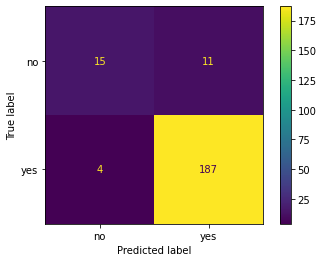

In [65]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lg)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [66]:
# Plot % Yes & Error
plts.plot_yes_perc_error(X_test_all, y_test, y_pred_lg) 

#### KNN

In [74]:
# Find best k for KNN model
best_k_dict, accuracies = ea.knn_analysis_hp(X_train, X_dev, y_train, y_dev)
best_k = best_k_dict["max_k"]

In [75]:
# Plot k vs accuracy - Move Pavan's code to function from knn_analysis.py

In [76]:
# Make prediction with best k

# !TO MOVE TO A FUNCTION
classifier = KNeighborsClassifier(n_neighbors=best_k)
classifier.fit(X_train, y_train)
y_pred_knn = classifier.predict(X_test)

In [77]:
# Accuracy & F-Score
print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("F score: ", f1_score(y_test, y_pred_knn))
print("Classification report: \n", classification_report(y_test, y_pred_knn))

Accuracy:  0.9032258064516129
F score:  0.9468354430379746
Classification report: 
               precision    recall  f1-score   support

         0.0       0.69      0.35      0.46        26
         1.0       0.92      0.98      0.95       191

    accuracy                           0.90       217
   macro avg       0.80      0.66      0.70       217
weighted avg       0.89      0.90      0.89       217



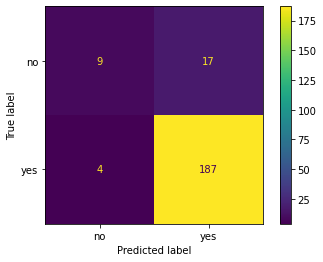

In [78]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [79]:
# Plot % Yes & Error
plts.plot_yes_perc_error(X_test_all, y_test, y_pred_knn) 

#### Decision Tree

In [88]:
# Find best params for decision tree
dt_best_params_dict, accuracies_dt = ea.decision_tree_hp(X_train, X_dev, y_train, y_dev)
accuracies_dt

KeyError: 'log_loss'

In [ ]:
# Make prediction with best params

# !TO MOVE TO A FUNCTION
def xx(dt_best_params_dict):
    clf_model = DecisionTreeClassifier(criterion=dt_best_params_dict["best_criterion"], 
                                       random_state=42, 
                                       max_depth=dt_best_params_dict["best_depth_tree"])
    clf_model.fit(X_train,y_train)
    y_pred = clf_model.predict(X_test)
    return (clf_model, y_pred)

In [ ]:
# Plot best decision tree - Move Pavan's code in decision_tree.py to function

In [ ]:
# Accuracy & F-Score
print("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("F score: ", f1_score(y_test, y_pred_dt))
print("Classification report: \n", classification_report(y_test, y_pred_dt))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [ ]:
# Plot % Yes & Error
plts.plot_yes_perc_error(X_test_all, y_test, y_pred_dt) 

#### Random Forest

In [97]:
# Find best params for Random Forest model
best_params_rf, best_acc_rf, accuracies_rf = rf.random_forest(X_train=X_train, X_dev=X_dev, 
                                            y_train=y_train, y_dev=y_dev, random_state = True)

AttributeError: 'DataFrame' object has no attribute 'display'

In [ ]:
accuracies_rf.display()

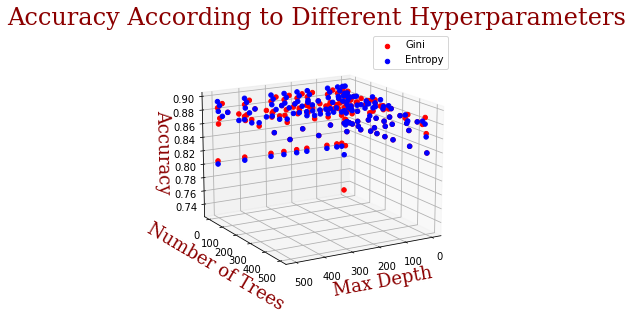

In [53]:
# Plot random forests' accuracies based on parameters
rf.plot_random_forest(accuracies)

In [96]:
# Make prediction with best model
y_test_pred_rf = rf.predict_random_forest(best_params_rf, X_train, y_train, X_test, random_state = True)

In [94]:
# Evaluation metrics 
print("Test Data - Classification Report: \n", classification_report(y_test, y_test_pred_rf))

NameError: name 'y_train_pred_rf' is not defined

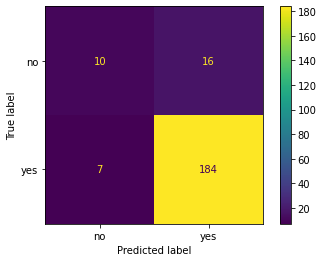

In [60]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [87]:
# REVIEW PLOT 
# Plot % Yes & Error
ys = plts.plot_yes_perc_error(X_test_all, y_test, y_pred_rf) 
print(ys)

Figure({
    'data': [{'customdata': array([['Bretonnières'],
                                   ['Mies'],
                                   ['Ropraz'],
                                   ['Hergiswil bei Willisau'],
                                   ['Pont-en-Ogoz'],
                                   ['Valeyres-sous-Ursins'],
                                   ['Küblis'],
                                   ['Sierre'],
                                   ['Granges-Paccot'],
                                   ['Amlikon-Bissegg'],
                                   ['Saubraz'],
                                   ['Bodio'],
                                   ['Würenlingen'],
                                   ['Wenslingen'],
                                   ['Engelberg'],
                                   ['Zwingen'],
                                   ['Savièse'],
                                   ['Lüterkofen-Ichertswil'],
                                   ['Kappel am Albis'],
   

#### Neural Networks 

In [ ]:
# Find best params for neural net

# MISSING IMPLEMENTATION
nn_best_params, accuracies = nn(X_train, X_dev, y_train, y_dev)

In [ ]:
# Plots??

In [ ]:
# Make prediction with best model 

# MISSING IMPLEMENTATION 
y_pred_nn = []

In [ ]:
# Accuracy & F-Score
print("Accuracy: ", accuracy_score(y_test, y_pred_nn))
print("F score: ", f1_score(y_test, y_pred_nn))
print("Classification report: \n", classification_report(y_test, y_pred_nn))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [ ]:
# Plot % Yes & Error
plts.plot_yes_perc_error(X_test_all, y_test, y_pred_nn) 

### Conclusions

In [ ]:
# Table comparing best models and accuracies?